# Explore extracted BETA-Features based on SSD

### 0) Load packages and functions

In [ ]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from itertools import compress, product
import pandas as pd
import numpy as np

import sklearn as sk
from scipy import signal, stats
from scipy.signal import hilbert

import matplotlib.pyplot as plt



In [ ]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [ ]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')
feat_path = os.path.join(projectpath, 'results', 'features')

In [ ]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
# own data exploration functions
import lfpecog_features.get_ssd_data as ssd

import lfpecog_plotting.phase_plotting as phasePlot
import lfpecog_plotting.plotHelpers as pltHelp


import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults

import lfpecog_analysis.load_SSD_features as load_ssdFts
import lfpecog_features.feats_phases as phaseFts

import lfpecog_analysis.get_acc_task_derivs as importAcc


from lfpecog_plotting.plotHelpers import remove_duplicate_legend

### 1a) Define settings and Load Features and Acc-data

In [ ]:
SETTINGS = utilsFiles.load_ft_ext_cfg(cfg_fname='ftExtr_spectral_v1.json')

ssd_ft_path = os.path.join(feat_path, 'SSD_feats',
                           SETTINGS['DATA_VERSION'],
                           f"windows_{SETTINGS['WIN_LEN_sec']}s_"
                           f"{SETTINGS['WIN_OVERLAP_part']}overlap")
IGNORE_PTS = ['010', '011']  # 011 did not start in OFF, 010: check ECoG

SUBS_STUN_EFFECT = ['009', '014', '016']

In [ ]:
# get all available subs with features 
SUBS = list(set([name.split('_')[1] for name in os.listdir(ssd_ft_path)]))

for sub in IGNORE_PTS:
    if sub in SUBS: SUBS.remove(sub)

Load SSD-features

In [190]:
importlib.reload(load_ssdFts)
importlib.reload(phaseFts)

# load all SSDd features
fts = load_ssdFts.ssdFeatures(
    # sub_list=['009']
)


load SSDd features for sub-009

load SSDd features for sub-014

load SSDd features for sub-016

load SSDd features for sub-012

load SSDd features for sub-008

load SSDd features for sub-011

load SSDd features for sub-013


Load acc and task-labels

In [ ]:
importlib.reload(importAcc)
accs, labels = {}, {}
for sub in fts.sub_list:
    print(f'start sub {sub}')
    accs[sub], labels[sub] = importAcc.load_acc_and_task(
        sub=sub, dataversion='v3.0', resample_freq=500)

### 1b) Load Clinical Scores and define OFF vs ON

OFF definition:
    
    - up to 15 minutes after L-Dopa intake (max. dopa_time is 15)
    
    - no CDRS in total (max. CDRS total is 0)

    
ON definition:
    
    - at least 45 minutes after L-Dopa intake (min. dopa time is 45)
    
    - no severe Dyskinesia (max CDRS total is 5)


Stun-effect: sub-analysis on patients with significant OFF-reduction after OR versus pre-operative

get individual OFF and ON selection

In [ ]:
importlib.reload(importAcc)

INCL_TASKS = ['rest']
PLOT_MED_SELECTION = False

MAX_OFF_MIN = 15
MAX_OFF_CDRS = 0
MIN_ON_MIN = 60
MAX_ON_CDRS = 5

# define folders to store
fig_dir = os.path.join(
    utilsFiles.get_beta_project_path('figures'),
    'off_on_definition',
    f'OFF_{MAX_OFF_MIN}min_{MAX_OFF_CDRS}cdrs_'
    f'ON_{MIN_ON_MIN}min_{MAX_ON_CDRS}cdrs')
if not os.path.exists(fig_dir): os.makedirs(fig_dir)

med_state_select = {}

for sub in SUBS:
    # dict to store off-on selection    
    med_state_select[sub] = {'OFF': {}, 'ON': {}}

    off_sel, on_sel = importAcc.define_OFF_ON_times(
        feat_times=getattr(fts, f'sub{sub}').powers.index.values.copy(),
        cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
        cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy(),
        max_OFF_minutes=MAX_OFF_MIN,
        max_OFF_cdrs=MAX_OFF_CDRS,
        min_ON_minutes=MIN_ON_MIN,
        max_ON_CDRS=MAX_ON_CDRS,
        incl_tasks=INCL_TASKS,
        labels_df=labels[sub]
    )
    med_state_select[sub]['OFF'] = off_sel
    med_state_select[sub]['ON'] = on_sel
    
    if PLOT_MED_SELECTION:
        fig_fname = f'{sub}_on_off_moments_powers'
        # load CDRS scores of both raters to plot
        cdrss = {}
        for rater in ['Patricia', 'Jeroen']:
            cdrss[rater[0]] = importClin.read_clinical_scores(sub=sub, rater=rater)
        # load feature times to plot
        sub_ft_times = getattr(fts, f'sub{sub}').powers.index.values.copy()
        if np.nanmax(sub_ft_times) > 200:
            sub_ft_times /= 60  # feature window times in minutes

        for r, rater in enumerate(['J', 'P']):  
            plt.scatter(cdrss[rater]['dopa_time'] + (1*r),
                        cdrss[rater]['CDRS_total'],
                        label=rater)

        plt.scatter(sub_ft_times, [-.5] * len(sub_ft_times),
                    color='gray', alpha=.3, label='features available')
        
        plt.fill_between(x=sub_ft_times, where=off_sel, label='OFF',
                         y1=10, y2=15,alpha=.3,
                         color=pltHelp.get_colors()['turquoise'],)
        
        plt.fill_between(x=sub_ft_times, where=on_sel,label='ON',
                         y1=10, y2=15, alpha=.3,
                         color=pltHelp.get_colors()['darkgreen'],)

        plt.title(f'Sub {sub} (tasks incl.: {INCL_TASKS})'
                  f'\n(OFF: max {MAX_OFF_MIN} minutes, max {MAX_OFF_CDRS} cdrs;'
                  f' ON: min {MIN_ON_MIN} minutes, max {MAX_ON_CDRS} cdrs)')
        plt.xlabel('Time (relative to L-Dopa intake)')
        plt.ylabel('Total CDRS score')
        plt.legend(ncol=5)
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, fig_fname), dpi=150,
                    facecolor='w')
        plt.close()
    


In [ ]:
# fts.sub011.coherences.STN_STN.hi_beta.imag_coh

### 1c) Select Features 

In [ ]:
vars(fts.sub013).keys()

show coherence OFF ON differences

In [ ]:
coh_values

In [ ]:
sub = '008'
coh_values = getattr(fts, f'sub{sub}').coherences.STN_ECOG.hi_beta.imag_coh

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].imshow(coh_values.T, aspect=4,)
xticks = np.linspace(0, coh_values.shape[0]-1, 5).astype(int)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(np.around(coh_values.index.values[xticks] / 60))
yticks = np.linspace(0, coh_values.shape[1]-1, 5).astype(int)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(coh_values.keys()[yticks])

axes[0].invert_yaxis()

axes[0].set_xlabel('Time (minutes after L-Dopa intake)')
axes[0].set_ylabel('Frequency (Hz)')

coh_times = coh_values.index.values

off_sel, on_sel = importAcc.define_OFF_ON_times(
    feat_times=coh_times,
    cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
    cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy(),
    max_OFF_minutes=MAX_OFF_MIN,
    max_OFF_cdrs=MAX_OFF_CDRS,
    min_ON_minutes=45,
    max_ON_CDRS=8,
    incl_tasks=INCL_TASKS,
    labels_df=labels[sub]
)
# PLOT ALL
# for w in np.arange(coh_values.shape[0]):
#     plt.plot(coh_values.iloc[w], alpha=.1, c='blue')

# plt.axis('off')

# PLOT OFF and ON
axes[1].plot(coh_values.values[off_sel, :].T,
             alpha=.3, c='gray',
             label='OFF')
axes[1].plot(coh_values.values[on_sel, :].T,
             alpha=.3, c='orangered',
             label='ON')

axes[1].set_xlabel('frequency (Hz)')
axes[1].set_ylabel('Squared coherence (a.u.)')

# TODO: ADD LABELTICKS

leg_content = axes[1].get_legend_handles_labels()
hndls, labs = pltHelp.remove_duplicate_legend(leg_content)
axes[1].legend(hndls, labs)

plt.show()

In [ ]:
coh_values = getattr(fts, f'sub{sub}').coherences.STN_ECOG.hi_beta.sq_coh.copy()
print(coh_values.shape)
plt.plot(
    coh_values.index,
    coh_values.mean(axis=1)
)

In [ ]:
from lfpecog_analysis.get_acc_task_derivs import define_OFF_ON_times

In [ ]:
sub = '008'

# show coherences

off_values = []
on_values = []

sub_coh_values = getattr(fts, f'sub{sub}').coherences

coh_df = sub_coh_values.STN_ECOG.lo_beta.sq_coh.copy()
coh_values = coh_df.mean(axis=1)
coh_times = coh_df.index

off_sel, on_sel = define_OFF_ON_times(
    feat_times=coh_times,
    cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
    cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy()     
)

off_values = coh_values.values[off_sel]
on_values = coh_values.values[on_sel]

plt.boxplot([off_values, on_values])
plt.show()



#### explore PAC

In [ ]:
# TODO: save out figures to OneDrive

importlib.reload(phasePlot)
fsize=14
PAC_METRIC = 'mean'

for sub in SUBS:
    if sub != '014': continue

    for i_t, TASK in enumerate(['rest', 'tap']):
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # show PACs
        off_values = []
        on_values = []

        sub_pac_values = getattr(fts, f'sub{sub}').localPAC

        ecog_side = importClin.get_ecog_side(sub)
        src = f'ecog_{ecog_side}'
        # src = 'lfp_right'
        bw = 'lo_beta_narrow_gamma'
        pac_sel = sub_pac_values[f'{src}_{bw}']

        if PAC_METRIC == 'mean':
            pac_summary = pac_sel.values.mean(axis=0).mean(axis=0)
        elif PAC_METRIC == 'max':
            pac_summary = pac_sel.values.max(axis=0).max(axis=0)

        pac_arr = pac_sel.values.copy()
        pac_times = pac_sel.times.copy()

        off_sel, on_sel = define_OFF_ON_times(
            feat_times=pac_times,
            cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
            cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy(),
            incl_tasks=TASK,
            labels_df=labels[sub],
        )
        if sum(off_sel) == 0 and sum(on_sel) == 0:
            plt.close()
            print(f'sub {sub} skipped, no data OFF and ON for {TASK}')
            continue

        
        off_pac = np.nanmean(pac_arr[:, :, off_sel], axis=-1)
        on_pac = np.nanmean(pac_arr[:, :, on_sel], axis=-1)
        sub_max_pac = np.nanmax([np.nanmax(off_pac), np.nanmax(on_pac)])

        axes[0] = phasePlot.plot_pac_comodulogram(
            pac_arr_2d=off_pac,
            pha_bin_tuples=pac_sel.pha_bins,
            amp_bin_tuples=pac_sel.amp_bins,
            plot_title=f'OFF ({TASK})',
            plot_on_ax=axes[0],
            fig_axis=fig,
            vmax=sub_max_pac)
        axes[1] = phasePlot.plot_pac_comodulogram(
            pac_arr_2d=on_pac,
            pha_bin_tuples=pac_sel.pha_bins,
            amp_bin_tuples=pac_sel.amp_bins,
            plot_title=f'ON ({TASK})',
            plot_on_ax=axes[1],
            fig_axis=fig,
            vmax=sub_max_pac)
        
        plt.suptitle(f'PAC - sub {sub} ({bw}, in {src})',
                    size=fsize, color='darkgray',
                    x=.5, y=.99, ha='center',
                    weight='bold')
        plt.close()


In [ ]:
pha_range = (12, 20)
amp_range = (60, 90)
pha_bin_width = 2
amp_bin_resolution = 4

fs = ssd_dat.ecog_right.fs
pha_sig = ssd_dat.ecog_right.lo_beta
amp_sig = ssd_dat.ecog_right.narrow_gamma
temptimes = ssd_dat.ecog_right.times

pactemp = phaseFts.calculate_PAC_matrix(
    sig_pha=pha_sig,
    sig_amp=amp_sig,
    fs=fs,
    freq_range_pha=pha_range,
    freq_range_amp=amp_range,
    dynamic_bin_widths=False,
    return_1_MI=True,
    window_times=temptimes,
    surrogate_method='swap',
    norm_method='Zscore',
    verbose=True
)


#### 1d) Extract burst-features

In [192]:
import lfpecog_features.bursts_funcs as burstFuncs
import lfpecog_features.feats_helper_funcs as ftHelpers
import lfpecog_features.bursts_main as burstMain

In [208]:
list(pltHelp.get_colors().values())[0]

'#332288'

In [217]:
importlib.reload(ssd)
importlib.reload(burstFuncs)
importlib.reload(burstMain)

# ADD OFF vs ON grouping

# define settings
SMOOTH_MILLISEC = 250
TO_SAVE_FIG = True
fig_dir = os.path.join(
        utilsFiles.get_beta_project_path('figures'),
        'bursts', 'burst_rates')

# try to call from feats_extract_multivar.py
for sub in SUBS[4:5]:

    burstMain.get_burst_features_SSD(
        sub=sub,
        SMOOTH_MILLISEC=SMOOTH_MILLISEC,
        TO_SAVE_FIG=True,
        FIG_DIR=fig_dir,
        SPLIT_OFF_ON=True,
    )

# check if OFF ON SPLITTING CAN BE SPEEDENED UP

# clean up 2d plot regrading labels axes titles legends


start 008, burst feature-extraction

load SSDd features for sub-008
	...loaded SSD windowed-data and meta-info for ecog_left of sub-008
	...loaded SSD windowed-data and meta-info for lfp_left of sub-008
	...loaded SSD windowed-data and meta-info for lfp_right of sub-008


In [211]:
importlib.reload(importAcc)

<module 'lfpecog_analysis.get_acc_task_derivs' from 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\code\\lfpecog_analysis\\get_acc_task_derivs.py'>

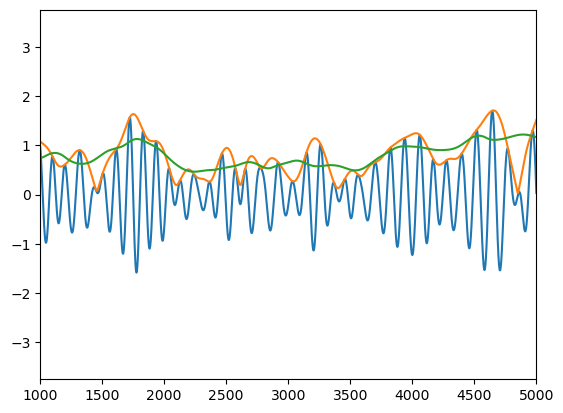

In [167]:
plt.plot(sig)
env = abs(hilbert(sig.copy()))
plt.plot(env)

env_smooth = env.copy()
env_smooth = ftHelpers.smoothing(sig=env_smooth,
                        win_ms=250, fs=fs)

plt.plot(env_smooth)
plt.xlim(1000, 5000)

plt.show()

In [ ]:
importlib.reload(phaseFts)


In [ ]:


# plt.plot(lo_beta_off[10], label='lo-B')
# plt.plot(hi_beta_off[10], label='hi-B')
# plt.legend()
# plt.xlim(0, 5000)
# plt.show()

# plt.plot(lo_beta_on[10], label='lo-B')
# plt.plot(hi_beta_on[10], label='hi-B')
# plt.legend()
# plt.xlim(0, 5000)
# plt.show()

### 2) Explore

In [ ]:
import lfpecog_plotting.plotHelpers as pltHelp
# pltHelp.get_colors()

In [ ]:
X_total = []
y_total_binary = []
y_total_scale = []
sub_ids_total = []
ft_times_total = []

EXCL_CODE = 99

TO_PLOT = False

if TO_PLOT:
    fig, axes = plt.subplots(len(SUBS), 1, figsize=(12, 16))
    fs = 16


for i_s, sub in enumerate(SUBS):
    # create lists to store values for boxplotting
    bp_LID_values_list = []
    bp_noLID_values_list = []
    bp_keys = []


    ### Create Y-labels based on CDRS (FT_LABELS)
    no_LID_sel = np.array(FT_LABELS[sub]) == 0
    LID_sel = np.array(FT_LABELS[sub]) >= LID_SCORE_INCL

    # create binary y-labels
    sub_y_bin = []  # y as binary
    for noLID, LID in zip(no_LID_sel, LID_sel):
        if noLID: sub_y_bin.append(0)
        elif LID: sub_y_bin.append(1)
        else: sub_y_bin.append(EXCL_CODE)
    # add full scaled y-labels
    sub_y_scale = FT_LABELS[sub]

    # append sub-codes to sub-id list
    sub_ids_total.append([sub] * FEATS[sub].shape[0])  # add subject code, as many times as there are feature rows

    # add subjects ft-times to list
    ft_times_total.append(FEATS[sub].index.values)

    ### Create X with standardised Feature-arrays
    sub_X = np.zeros_like((FEATS[sub]))

    for n_col, ft in enumerate(FEATS[sub].keys()):
        values = FEATS[sub].values[:, n_col]
        # split values on Dyskinesia
        noLID_values = values[no_LID_sel]
        LID_values = values[LID_sel]
        
        # define mean and std of no-LID for Z-SCORE
        m = np.nanmean(noLID_values)
        sd = np.nanstd(noLID_values)
        # Z-SCORE values
        Z_LID_values = (LID_values - m) / sd
        Z_noLID_values = (noLID_values - m) / sd
        Z_ALL_values = (values - m) / sd

        # add feat and z-score values to lists for BOXPLOT (WITHOUT NaNs)
        bp_LID_values_list.append(list(Z_LID_values[~np.isnan(LID_values)]))
        bp_keys.append(ft)

        # store all feats for pred-exploration
        sub_X[:, n_col] = Z_ALL_values
    
    X_total.append(sub_X)
    y_total_binary.append(sub_y_bin)
    y_total_scale.append(sub_y_scale)

    if TO_PLOT:
        ##### PLOT BOXPLOT OF FEATURES ######
        box = axes[i_s].boxplot(bp_LID_values_list)
        plt.setp(box['fliers'], color='gray')
        # plt.setp(box['whiskers'], color='red')

        axes[i_s].axhline(y=0, xmin=0, xmax=24, color='k', alpha=.3)
        for y_line in [-2, 2]: axes[i_s].axhline(y=y_line, xmin=0, xmax=24, color='r', alpha=.3)

        axes[i_s].set_ylim(-6, 6)
        axes[i_s].set_ylabel(f'z-scores\nvs no-LID (a.u.)', fontsize=fs)
        axes[i_s].set_title(f'Sub-{sub} (mean unilat. CDRS '
                            f'{round(np.mean(FT_LABELS[sub]), 2)})',
                            weight='bold', fontsize=fs)
        axes[i_s].set_xticklabels(['mx', 'mn', 'cv'] * int(len(bp_keys) / 3),
                                fontsize=fs,)

        for side in ['top','right','bottom']:
            axes[i_s].spines[side].set_visible(False)

        ### fill colors
        colors = {
            'alpha': 'yellow',
            'lo_beta': 'lightblue',
            'hi_beta': 'darkblue',
            'midgamma': 'green'
        }
        hatches = {
            'STN': '',
            'ECoG': '//'
        }

        x_fill_list = []
        for x1 in np.arange(.5, len(bp_keys) + .5, 3):
            x2 = x1 + 3
            x_fill_list.append([x1, x2])

        for i_x, (src, bw) in  enumerate(product(hatches.keys(), colors.keys())):
            axes[i_s].fill_betweenx(
                y=np.arange(-6, 6), x1=x_fill_list[i_x][0],
                x2=x_fill_list[i_x][1], color=colors[bw], hatch=hatches[src],
                label=f'{src} {bw}', alpha=.2, edgecolor='gray',)
if TO_PLOT:
    leg_content = plt.gca().get_legend_handles_labels()
    handles, labels = pltHelp.remove_duplicate_legend(leg_content)
    plt.legend(handles, labels, ncol=4, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False,
            prop={'weight': 'bold', 'size': fs})

    plt.suptitle('Individual Feature values during Dyskinesia\n', weight='bold', fontsize=fs+4)
    plt.tight_layout()

    figname = 'LID_ssdFeatures_boxplots_indiv'
    # plt.savefig(os.path.join(figpath, 'ft_exploration', 'SSD', figname),
    #             dpi=300, facecolor='w',)
    plt.close()

print(f'FEATURES X-AXIS: {bp_keys}')
